In [3]:
# ✅ Essential installs for MedMNIST, TorchSummary, and dependencies
!pip install -q medmnist
!pip install -q torchsummary
!pip install -q torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.7 MB/s eta 0:00:00


In [4]:
# Core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Dataset and visualization
import medmnist
from medmnist import INFO
from torchvision import transforms
from torchsummary import summary


In [5]:
# Visualization libraries
from torchsummary import summary
import medmnist
from medmnist import INFO
from torchvision import transforms
import torchvision

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🔧 Device:", device)

🔧 Device: cpu


In [6]:
# Step 2: CNN Model Definition
class CNN(nn.Module):
    def __init__(self, num_classes=9):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


100%|██████████| 206M/206M [00:09<00:00, 20.8MB/s]
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


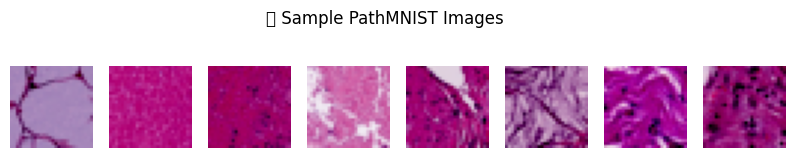

In [7]:

# Step 3: Dataset Loading and Visualization
# Load PathMNIST dataset

data_flag = 'pathmnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=transform, download=download)
test_dataset = DataClass(split='test', transform=transform, download=download)

# Show dataset sample images
sample_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
data_iter = iter(sample_loader)
images, labels = next(data_iter)

plt.figure(figsize=(10, 2))
for idx in range(8):
    plt.subplot(1, 8, idx+1)
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    plt.axis('off')
plt.suptitle("🔍 Sample PathMNIST Images")
plt.show()


In [8]:
# Show CNN model architecture
model_temp = CNN().to(device)
summary(model_temp, (3, 28, 28))

# Step 4: Split into 5 hospitals
NUM_CLIENTS = 5
total_samples = len(train_dataset)
base_size = total_samples // NUM_CLIENTS
split_sizes = [base_size] * (NUM_CLIENTS - 1)
split_sizes.append(total_samples - sum(split_sizes))

hospital_datasets = random_split(train_dataset, split_sizes)
test_loader = DataLoader(test_dataset, batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                  [-1, 128]         401,536
            Linear-6                    [-1, 9]           1,161
Total params: 422,089
Trainable params: 422,089
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.36
Params size (MB): 1.61
Estimated Total Size (MB): 1.98
----------------------------------------------------------------


In [9]:
# Step 5: Differential Privacy Noise Function
def apply_dp(model, noise_scale=1e-3):
    for param in model.parameters():
        if param.grad is not None:
            noise = torch.normal(0, noise_scale, size=param.grad.shape).to(param.device)
            param.grad += noise

# Step 6: Local Training with DP
def local_train_dp(model, dataloader, epochs=1, lr=0.001, dp=True, noise_scale=1e-3):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for _ in range(epochs):
        for x, y in dataloader:
            x, y = x.to(device), y.squeeze().to(device)
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, y)
            loss.backward()
            if dp:
                apply_dp(model, noise_scale=noise_scale)
            optimizer.step()

# Step 7: Model Weight Utilities
def get_model_weights(model):
    return {k: v.cpu().clone() for k, v in model.state_dict().items()}

def set_model_weights(model, weights):
    model.load_state_dict(weights)

def average_weights(weights_list):
    avg_weights = {}
    for key in weights_list[0].keys():
        avg_weights[key] = sum(w[key] for w in weights_list) / len(weights_list)
    return avg_weights

# Step 8: Evaluation Function
def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.squeeze().to(device)
            preds = model(x)
            _, predicted = torch.max(preds, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    return correct / total




In [10]:
# Step 9: Federated Training Loop with Visualization
round_accuracies = []
global_model = CNN().to(device)

for rnd in range(5):
    print(f"\n🔐🌐 Federated Round {rnd+1} | 🔏 Differential Privacy Enabled")

    local_weights = []

    for i in range(5):
        local_model = deepcopy(global_model)
        local_loader = DataLoader(hospital_datasets[i], batch_size=64, shuffle=True)
        local_train_dp(local_model, local_loader, epochs=1)
        local_weights.append(get_model_weights(local_model))

    avg_weights = average_weights(local_weights)
    set_model_weights(global_model, avg_weights)

    acc = evaluate_model(global_model, test_loader)
    round_accuracies.append(acc)
    print(f"✅ Global Accuracy after Round {rnd+1}: {acc:.4f} 🔒 Secure | 📊 Auditable")




🔐🌐 Federated Round 1 | 🔏 Differential Privacy Enabled
✅ Global Accuracy after Round 1: 0.6696 🔒 Secure | 📊 Auditable

🔐🌐 Federated Round 2 | 🔏 Differential Privacy Enabled
✅ Global Accuracy after Round 2: 0.7574 🔒 Secure | 📊 Auditable

🔐🌐 Federated Round 3 | 🔏 Differential Privacy Enabled
✅ Global Accuracy after Round 3: 0.8007 🔒 Secure | 📊 Auditable

🔐🌐 Federated Round 4 | 🔏 Differential Privacy Enabled
✅ Global Accuracy after Round 4: 0.8219 🔒 Secure | 📊 Auditable

🔐🌐 Federated Round 5 | 🔏 Differential Privacy Enabled
✅ Global Accuracy after Round 5: 0.8354 🔒 Secure | 📊 Auditable


<ipython-input-11-c0ce4a5fa38c>:15: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-11-c0ce4a5fa38c>:15: UserWarning: Glyph 128274 (\N{LOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-11-c0ce4a5fa38c>:15: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128274 (\N{LOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


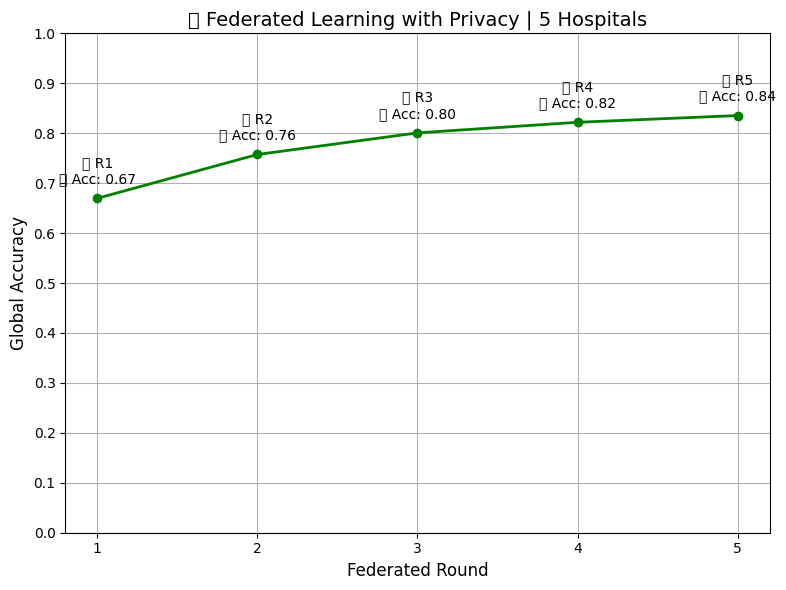

In [11]:
# Step 10: Accuracy Visualization
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(round_accuracies) + 1), round_accuracies, marker='o', color='green', linewidth=2)
plt.title("🔐 Federated Learning with Privacy | 5 Hospitals", fontsize=14)
plt.xlabel("Federated Round", fontsize=12)
plt.ylabel("Global Accuracy", fontsize=12)
plt.ylim(0, 1)
plt.grid(True)
plt.xticks(range(1, len(round_accuracies) + 1))
plt.yticks(np.linspace(0, 1, 11))

for i, acc in enumerate(round_accuracies):
    plt.text(i + 1, acc + 0.03, f"🔒 R{i+1}\n🧠 Acc: {acc:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()